In [293]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
# import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [462]:
from wordcloud import WordCloud

**Данные** <br>

In [346]:
df_ = pd.read_pickle('notebooks/data/data_preproc_all.pkl')
df = df_.rename(columns = {'Компания':'Broker', 'Заголовок':'Title',
        'sentence':'Review Text', 'Время':'data', 'Оценка':'Rating', 
       'sentence_proc':'text_lemma'})
df = df.dropna(subset='Статус')



In [347]:
df['Rating'] = df.Rating.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3244 entries, 0 to 3509
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Broker         3244 non-null   object
 1   url жалобы     3244 non-null   object
 2   Title          3244 non-null   object
 3   Статус         3244 non-null   object
 4   Review Text    3244 non-null   object
 5   data           3244 non-null   object
 6   Rating         3244 non-null   int32 
 7   Оценка выплат  0 non-null      object
 8   text_lemma     3244 non-null   object
dtypes: int32(1), object(8)
memory usage: 240.8+ KB


In [348]:
df["Word Count"] = df.text_lemma.apply(len)
# Character Length
df["Character Count"] = df.text_lemma.apply(len)
# Boolean for Positive and Negative Reviews
# df.loc[df.Rating >= 4,["Label"]] = 1
df['Label']=np.where(df.Rating > 3,1,0)

In [349]:
df['text_lemma_set'] = df.text_lemma.apply(set)
df['text_lemma_string'] = df.text_lemma.apply(' '.join)

**Общая аналитика** <br>




# Распределение оценок по брокерам

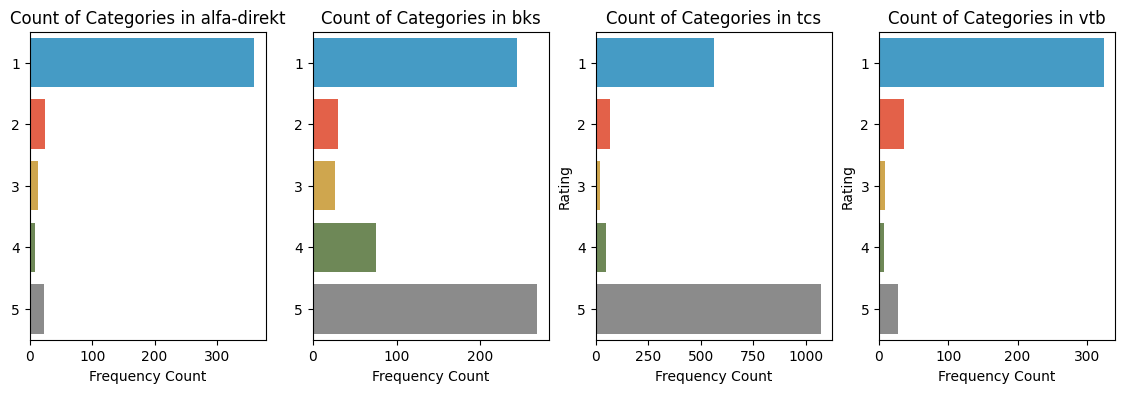

In [360]:
row_plots = df["Broker"].unique()
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=df[df.Broker==x].Rating, data=df[df.Broker==x], ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel(x)
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("")
axes[1].set_ylabel("")
plt.show()

In [233]:
df.Label.value_counts()

0    1717
1    1527
Name: Label, dtype: int64

In [456]:
# топ встречающихся слов
Counter(df[df.Label == 0].explode('text_lemma').text_lemma.values).most_common()

[('счёт', 3106),
 ('брокер', 2597),
 ('акция', 1901),
 ('иис', 1462),
 ('брокерский', 1372),
 ('клиент', 1365),
 ('бумага', 1309),
 ('поддержка', 1243),
 ('приложение', 1178),
 ('свой', 1153),
 ('инвестиция', 1152),
 ('деньга', 1077),
 ('ответ', 1056),
 ('перевод', 1056),
 ('вопрос', 1012),
 ('проблема', 1004),
 ('сотрудник', 966),
 ('получить', 882),
 ('чат', 880),
 ('обращение', 799),
 ('перевести', 752),
 ('заявка', 751),
 ('офис', 751),
 ('время', 743),
 ('решить', 736),
 ('актив', 675),
 ('месяц', 639),
 ('срок', 615),
 ('написать', 614),
 ('ситуация', 605),
 ('рубль', 600),
 ('средство', 591),
 ('поручение', 589),
 ('открыть', 581),
 ('сумма', 566),
 ('закрыть', 561),
 ('комиссия', 549),
 ('должный', 535),
 ('писать', 527),
 ('информация', 514),
 ('документ', 509),
 ('ценный', 484),
 ('продать', 481),
 ('работать', 477),
 ('закрытие', 467),
 ('ошибка', 463),
 ('ваш', 440),
 ('отделение', 434),
 ('никакой', 431),
 ('ждать', 429),
 ('ответить', 428),
 ('прийти', 413),
 ('итог', 411

In [482]:
from nltk.util import ngrams
l = list(df[['text_lemma_set']].explode('text_lemma_set').text_lemma_set.values)
# n_grams = ngrams(l,2)
# a = [' '.join(grams) for grams in n_grams]

s = (',').join(l)
s[0:100]


'возможный,сервис,вариант,связаться,помощь,сберегательный,консультант,предоставить,рассчитать,инвести'

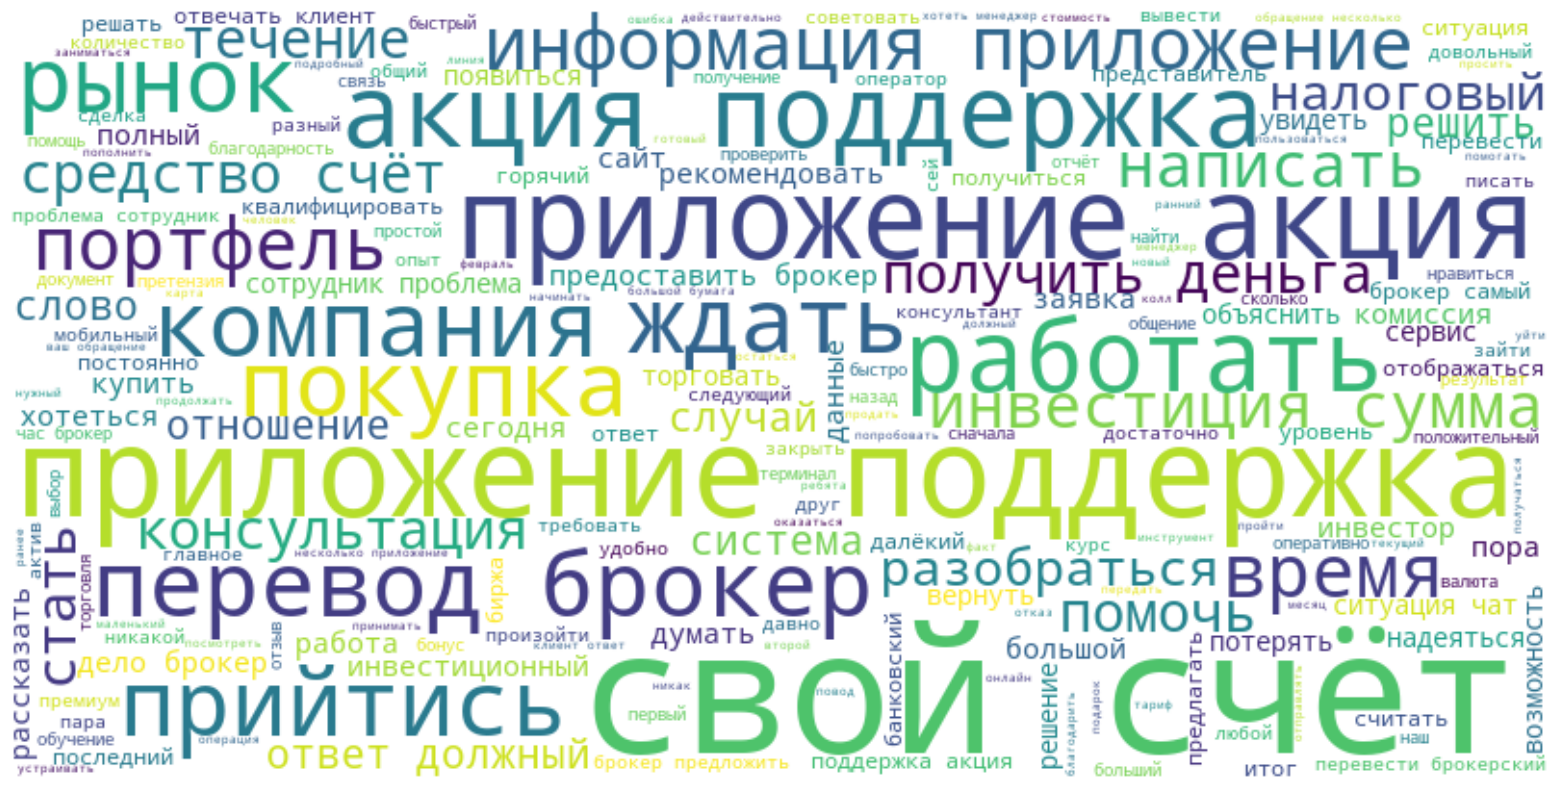

In [483]:

wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=set(',')).generate(s)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [291]:
# df[(df.Label == 1) & (df['Broker']=='bks')]

### Таблица топ обращений по n-gram

In [157]:
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]


#gramfreq(l,3,30)
# pd.DataFrame(gramfreq(l,3,30).reset_index())

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(data,i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [221]:
data_list

['инвестиция',
 'видимо',
 'рекламный',
 'вещь',
 'сравнить',
 'подумывать',
 'отзыв',
 'недальновидность',
 'выбрать',
 'звоночек',
 'бюджет',
 'пустить',
 'классный',
 'писать',
 'партнёр',
 'сочувствовать',
 'брокерский',
 'уметь',
 'ответственный',
 'акционер',
 'объявить',
 'волновать',
 'слоган',
 'достигнуть',
 'истеблишмент',
 'человек',
 'большой',
 'бумага',
 'обслуживание',
 'качество',
 'лицо',
 'частность',
 'слишком',
 'позволить',
 'смотреть',
 'клиент',
 'решение',
 'первый',
 'обдуманный',
 'реклама',
 'думать',
 'хотеться',
 'догонять',
 'недальновидный',
 'план',
 'действие',
 'агрессивный',
 'сайт',
 'частенько',
 'маленький',
 'осваивать',
 'целое',
 'являться',
 'отток',
 'выбирать',
 'информация',
 'приложение',
 'выступать',
 'удержать',
 'судьба',
 'совершенно',
 'мусорк',
 'открытие',
 'брокер',
 'ребрейдинг',
 'вкладка',
 'ликвидировать',
 'нога',
 'развитие',
 'опечалиться',
 'наработка',
 'свой',
 'продукт',
 'всплывать',
 'подобный',
 'бак',
 'колонка',
 '

In [446]:
df_broker_negative = pd.DataFrame(index=None)
for broker in df['Broker'].unique():
    data = df[(df['Broker']==broker)].copy()  # (df.Label == 0) &
    data_list = list(data[['text_lemma_set']].explode('text_lemma_set').text_lemma_set.values)
    table = gram_table(data= data_list, gram=[2,3,4,5], length=15)
    # table['broker'] = broker
    table.insert(0,'broker',broker)
    df_broker_negative = pd.concat([table,df_broker_negative]) 
df_broker_negative

,broker,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,vtb,свой счёт,115,перевод предоставить брокер,13,ваш несколько информация приложение,5,ваш несколько информация приложение поддержка,3
1,vtb,перевод брокер,45,ваш несколько информация,8,отдел обратиться первый срок,3,инвестиция видимо рекламный вещь сравнить,2
2,vtb,приложение поддержка,32,информация приложение поддержка,8,любой отправить утром перевод,3,подобный брокерский доход сделка ценный,2
3,vtb,предоставить брокер,31,несколько информация приложение,7,действовать открытие перевод брокер,3,доступный целое подобный брокерский доход,2
4,vtb,получить деньга,30,свой счёт оставить,7,биржа брокерский ценный условие,3,совершение доступный целое подобный брокерский,2
5,vtb,приложение акция,29,открытие перевод брокер,7,несколько информация приложение поддержка,3,образоваться совершение доступный целое подобный,2
6,vtb,информация приложение,28,приложение акция поддержка,6,игнорирование ненавидеть свинский онлайн,2,торговля образоваться совершение доступный целое,2
7,vtb,средство счёт,27,свой счёт пункт,6,удивительно биржевой учёт предыдущий,2,операция торговля образоваться совершение дост...,2
8,vtb,сотрудник проблема,25,информация приложение акция,6,документ значительно частный операция,2,исходящий операция торговля образоваться совер...,2
9,vtb,биржа брокерский,25,предложение свой счёт,6,целый документ значительно частный,2,заявка исходящий операция торговля образоваться,2


# О чем пишут 
Исходя из сгруппированных n_gram осноные топики по БКС: \
1 открытие/закрытие брокерского и ИИС счета \
2 вопросы по акциям и спец предложениям\
3 поддержка в мобильном приложении\
4 переводы средств со счета на счет\
5 вывод денег со счета \
6 пополение счета \
7 долгое рассмотрение документов



In [193]:
df[(df.Label == 0) & (df['Broker']=='alfa-direkt')]['Review Text']

2      Добрый деньНомер счета 1160988-000На каком осн...
3      Мой брокерский счёт перевели в "альфу" из ВТБ....
4      На написание отзыва меня сподвигло не решение ...
5      Доступ к торгам ИЦБ на СПБ бирже восстановлен,...
6      9.08.23 в 12:04 пришёл в офис обслуживания на ...
                             ...                        
252    Альфа-Инвестиции - худший брокер, с которым мн...
253    В Альфа-инвестиции я попала из ВТБ (обычный бр...
254    Видно очень много пострадавших от перевода сво...
255    В альфу ИИС переведен от ВТБ без моего согласи...
256    Здравствуйте! Таких жалоб как моя вижу уже мно...
Name: Review Text, Length: 210, dtype: object

In [215]:
for broker in df['Broker'].unique():
    data = df[(df.Label == 1) & (df['Broker']==broker)]['Review Text'][0:70]
    data.to_csv(f'{broker}_pos.csv')

### Анализ на регулярных выражениях

In [415]:
df_neg = df[df.Label == 0]
df_neg.shape

(1717, 14)

### Обращения по негативному рейтингу (1-3) отфильтрованные по ключевым словам

In [429]:
def fill_schet(df):
    match1 = df_neg.text_lemma_string.str.contains(r'открытие|закрытие|счет|сложность')
    match2 = df_neg.text_lemma_string.str.contains(r'сложность|неудобно')
    res = np.where(match1&match2, 1, 0)
    return res

df_neg['счет_neg'] = fill_schet(df_neg)
df_n1 = df_neg.groupby(['Broker']).agg({
    'счет_neg' : np.sum,
   'Label' : np.size
}).reset_index()
df_n1['счет_neg'] /= df_n1['Label']
df_n1#.drop(['Label'])

,Broker,счет_neg,Label
0,alfa-direkt,0.027638,398
1,bks,0.019934,301
2,tcs,0.016949,649
3,vtb,0.016260,369


In [416]:
# проблема с акциями
df_neg = df[df.Label == 0]

def fill_schet(df):
    match1 =  df_neg.text_lemma_string.str.contains(r'подарок|рекламный')

    res = np.where(match1, 1, 0)
    return res

df_neg['reklam'] = fill_schet(df_neg)
df_n2 = df_neg.groupby(['Broker']).agg({
    'reklam' : np.sum,
   'Label' : np.size
}).reset_index()
df_n2['reklam'] /= df_n2['Label']
df_n2#.drop(['Label'])

,Broker,reklam,Label
0,alfa-direkt,0.090452,398
1,bks,0.046512,301
2,tcs,0.075501,649
3,vtb,0.024390,369


In [430]:
# проблема с поддержкой компетентностью
df_neg = df[df.Label == 0]

def fill_schet(df):
    match1 =  df_neg.text_lemma_string.str.contains(r'некомпетен|знан')

    res = np.where(match1, 1, 0)
    return res

df_neg['neg_znan'] = fill_schet(df_neg)
df_n3 = df_neg.groupby(['Broker']).agg({
    'neg_znan' : np.sum,
   'Label' : np.size
}).reset_index()
df_n3['neg_znan'] /= df_n3['Label']
df_n3#.drop(['Label'])

,Broker,neg_znan,Label
0,alfa-direkt,0.060302,398
1,bks,0.043189,301
2,tcs,0.058552,649
3,vtb,0.067751,369


In [421]:
# проблема с моб приложением
df_neg = df[df.Label == 0]

def fill_schet(df):
    match1 =  df.text_lemma_string.str.contains(r'мобильный')
    match2 =  df.text_lemma_string.str.contains(r'приложение|версия')
    res = np.where(match1&match2, 1, 0)
    return res

df_neg['neg_mob'] = fill_schet(df_neg)
df_n4 = df_neg.groupby(['Broker']).agg({
    'neg_mob' : np.sum,
   'Label' : np.size
}).reset_index()
df_n4['neg_mob'] /= df_n4['Label']
df_n4#.drop(['Label'])

,Broker,neg_mob,Label
0,alfa-direkt,0.070352,398
1,bks,0.076412,301
2,tcs,0.055470,649
3,vtb,0.062331,369


In [424]:
# проблема с торговым терминалом
df_neg = df[df.Label == 0]

def fill_schet(df):
    match1 =  df.text_lemma_string.str.contains(r'терминал|баг')

    res = np.where(match1, 1, 0)
    return res

df_neg['terminal'] = fill_schet(df_neg)
df_n5 = df_neg.groupby(['Broker']).agg({
    'terminal' : np.sum,
   'Label' : np.size
}).reset_index()
df_n5['terminal'] /= df_n5['Label']
df_n5#.drop(['Label'])

,Broker,terminal,Label
0,alfa-direkt,0.045226,398
1,bks,0.029900,301
2,tcs,0.081664,649
3,vtb,0.027100,369


In [425]:
# проблема с коммиссиями
def fill_schet(df):
    match1 =  df_neg.text_lemma_string.str.contains(r'комиссия|рекламааный')

    res = np.where(match1, 1, 0)
    return res

df_neg['neg_comis'] = fill_schet(df_neg)
df_n6 = df_neg.groupby(['Broker']).agg({
   'neg_comis' : np.sum,
   'Label' : np.size
}).reset_index()
df_n6['neg_comis'] /= df_n6['Label']
df_n6 #.drop(['Label'])

,Broker,neg_comis,Label
0,alfa-direkt,0.077889,398
1,bks,0.159468,301
2,tcs,0.187982,649
3,vtb,0.124661,369


In [427]:
# проблема с дистанционным обслуживанием
def fill_schet(df):
    match1 =  df_neg.text_lemma_string.str.contains(r'подарок|рекламный')

    res = np.where(match1, 1, 0)
    return res

df_neg['neg_present'] = fill_schet(df_neg)
df_n7 = df_neg.groupby(['Broker']).agg({
    'neg_present' : np.sum,
    'Label' : np.size
}).reset_index()
df_n7['neg_present'] /= df_n7['Label']
df_n7 #.drop(['Label'])

,Broker,neg_present,Label
0,alfa-direkt,0.090452,398
1,bks,0.046512,301
2,tcs,0.075501,649
3,vtb,0.024390,369


In [433]:
# проблема с налогами

def fill_schet(df):
    match1 =  df_neg.text_lemma_string.str.contains(r'налог|вычет|отчёт')

    res = np.where(match1, 1, 0)
    return res

df_neg['neg_nalog'] = fill_schet(df_neg)
df_n8 = df_neg.groupby(['Broker']).agg({
    'neg_nalog' : np.sum,
   'Label' : np.size
}).reset_index()
df_n8['neg_nalog'] /= df_n8['Label']
df_n8 #.drop(['Label'])

,Broker,neg_nalog,Label
0,alfa-direkt,0.223618,398
1,bks,0.166113,301
2,tcs,0.232666,649
3,vtb,0.222222,369


In [447]:
# навязывание услуг
df_neg = df[df.Label == 0]

def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'навязывать')

    res = np.where(match1, 1, 0)
    return res

df_neg['naviaz'] = fill_schet(df_neg)
df_n9 = df_neg.groupby(['Broker']).agg({
    'naviaz' : np.sum,
   'Label' : np.size
}).reset_index()
df_n9['naviaz'] /= df_n9['Label']
df_n9 #.drop(['Label'])

,Broker,naviaz,Label
0,alfa-direkt,0.002513,398
1,bks,0.003322,301
2,tcs,0.009245,649
3,vtb,0.002710,369


### Преимущества брокеоов

In [448]:
df_positive = df[df.Label == 1]
df_positive.to_csv('_positives.csv')

In [393]:
# скорость обслуживания
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'быстрый|оперативный')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_fast'] = fill_schet(df_positive)
df_p1 = df_positive.groupby(['Broker']).agg({
    'pos_fast' : np.sum,
   'Label' : np.size
}).reset_index()
df_p1['pos_fast'] /= df_p1['Label']
df_p1

,Broker,pos_fast,Label
0,alfa-direkt,0.193548,31
1,bks,0.096210,343
2,tcs,0.117069,1119
3,vtb,0.000000,34


In [376]:
# удобное приложение
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'удобный|понятный')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_udob'] = fill_schet(df_positive)
df_p2 = df_positive.groupby(['Broker']).agg({
    'pos_udob' : np.sum,
   'Label' : np.size
}).reset_index()
df_p2['pos_udob'] /= df_p2['Label']
df_p2

,Broker,pos_udob,Label
0,alfa-direkt,0.015075,31
1,bks,0.192691,343
2,tcs,0.269646,1119
3,vtb,0.032520,34


In [392]:
# терминал
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'терминал')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_termin'] = fill_schet(df_positive)
df_p3 = df_positive.groupby(['Broker']).agg({
    'pos_termin' : np.sum,
   'Label' : np.size
}).reset_index()
df_p3['pos_termin'] /= df_p3['Label']
df_p3

,Broker,pos_termin,Label
0,alfa-direkt,0.000000,31
1,bks,0.058309,343
2,tcs,0.020554,1119
3,vtb,0.029412,34


In [389]:
# обучение советник
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'обучение|советник')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_obuch'] = fill_schet(df_positive)
df_p4 = df_positive.groupby(['Broker']).agg({
    'pos_obuch' : np.sum,
   'Label' : np.size
}).reset_index()
df_p4['pos_obuch'] /= df_p4['Label']
df_p4

,Broker,pos_obuch,Label
0,alfa-direkt,0.000000,31
1,bks,0.303207,343
2,tcs,0.056300,1119
3,vtb,0.088235,34


In [399]:
# широта выбора
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'широкий|понятный')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_udob'] = fill_schet(df_positive)
df_p5 = df_positive.groupby(['Broker']).agg({
    'pos_udob' : np.sum,
   'Label' : np.size
}).reset_index()
df_p5['pos_udob'] /= df_p5['Label']
df_p5

,Broker,pos_udob,Label
0,alfa-direkt,0.064516,31
1,bks,0.081633,343
2,tcs,0.080429,1119
3,vtb,0.176471,34


In [400]:
# низкие тарифы низк выгод тариф
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'низкий|выгодный')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_low_tar'] = fill_schet(df_positive)
df_p6 = df_positive.groupby(['Broker']).agg({
    'pos_low_tar' : np.sum,
   'Label' : np.size
}).reset_index()
df_p6['pos_low_tar'] /= df_p6['Label']
df_p6

,Broker,pos_low_tar,Label
0,alfa-direkt,0.193548,31
1,bks,0.119534,343
2,tcs,0.023235,1119
3,vtb,0.176471,34


In [404]:
# доступность торгов
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'выходной|удаленно')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_online'] = fill_schet(df_positive)
df_p7 = df_positive.groupby(['Broker']).agg({
    'pos_online' : np.sum,
   'Label' : np.size
}).reset_index()
df_p7['pos_online'] /= df_p7['Label']
df_p7

,Broker,pos_online,Label
0,alfa-direkt,0.000000,31
1,bks,0.020408,343
2,tcs,0.005362,1119
3,vtb,0.029412,34


In [408]:
# иностран китайск
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'иностран|китайск|юань')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_inostr'] = fill_schet(df_positive)
df_p8 = df_positive.groupby(['Broker']).agg({
    'pos_inostr' : np.sum,
   'Label' : np.size
}).reset_index()
df_p8['pos_inostr'] /= df_p8['Label']
df_p8

,Broker,pos_inostr,Label
0,alfa-direkt,0.064516,31
1,bks,0.087464,343
2,tcs,0.010724,1119
3,vtb,0.088235,34


In [452]:
# акции лояльность бонусы
def fill_schet(df):
    match1 = df.text_lemma_string.str.contains(r'лояльность|бонус')

    res = np.where(match1, 1, 0)
    return res

df_positive['pos_loyal'] = fill_schet(df_positive)
df_p9 = df_positive.groupby(['Broker']).agg({
    'pos_loyal' : np.sum,
   'Label' : np.size
}).reset_index()
df_p9['pos_loyal'] =  df_p9['pos_loyal']/df_p9['Label']
df_p9

,Broker,pos_loyal,Label
0,alfa-direkt,0.096774,31
1,bks,0.032070,343
2,tcs,0.056300,1119
3,vtb,0.000000,34


### Соединяем все в одну таблицу

In [484]:
# Относительная доля негативных отзывов по проблемам, найденным по ключевым словам

pd.concat([df_n1,df_n2,df_n3,df_n4,df_n5,df_n6,df_n7,df_n8,df_n9,],axis=1).drop(columns='Label')#.set_index('Broker')

,Broker,счет_neg,Broker,reklam,Broker,neg_znan,Broker,neg_mob,Broker,terminal,Broker,neg_comis,Broker,neg_present,Broker,neg_nalog,Broker,naviaz
0,alfa-direkt,0.027638,alfa-direkt,0.090452,alfa-direkt,0.060302,alfa-direkt,0.070352,alfa-direkt,0.045226,alfa-direkt,0.077889,alfa-direkt,0.090452,alfa-direkt,0.223618,alfa-direkt,0.002513
1,bks,0.019934,bks,0.046512,bks,0.043189,bks,0.076412,bks,0.029900,bks,0.159468,bks,0.046512,bks,0.166113,bks,0.003322
2,tcs,0.016949,tcs,0.075501,tcs,0.058552,tcs,0.055470,tcs,0.081664,tcs,0.187982,tcs,0.075501,tcs,0.232666,tcs,0.009245
3,vtb,0.016260,vtb,0.024390,vtb,0.067751,vtb,0.062331,vtb,0.027100,vtb,0.124661,vtb,0.024390,vtb,0.222222,vtb,0.002710



# Выводы по проблемам брокера БКС относительно конкурентов
1 Сложность со счетами (открытием и закрытием)  \
2 Проблемы с выводом средств \
3 Невыполние акций и заявленных условий  \
4 сбои в мобильном приложении \
5 вопросы по комиссиям и сборам

### БКС Брокеру не хватает

1 Проблемы с технической поддержкой - долгое ожидание ответов \
2 Сложности с дистанционным обслуживанием - многие операции требуют личного присутствия клиента в офисе, что неудобно. \
3 Невозможность решить проблемы удаленно - требование посещать определенный офис, где был открыт счет \
4 Сложности с получением необходимых документов и отчетов. \
5 Проблемы с зачислением средств, блокировкой счетов и выводом денег. \
6 Более прозрачные начисления и списания комиссий. \
7 Некомпетентные консультации менеджеров,в том числе по налогообложению. \
8 Более строгое выполнение условий по акциям и бонусам.

In [451]:
# Относительная доля положительных отзывов по проблемам, найденным по ключевым словам

pd.concat([df_p1,df_p2,df_p3,df_p4,df_p5,df_p6,df_p7,df_p8,df_p9,],axis=1).drop(columns='Label')

,Broker,pos_fast,Broker,pos_udob,Broker,pos_low_tar,Broker,pos_obuch,Broker,pos_udob,Broker,pos_low_tar,Broker,pos_online,Broker,pos_inostr,Broker,pos_udob
0,alfa-direkt,0.193548,alfa-direkt,0.129032,alfa-direkt,0.193548,alfa-direkt,0.000000,alfa-direkt,0.064516,alfa-direkt,0.193548,alfa-direkt,0.000000,alfa-direkt,0.064516,alfa-direkt,0.064516
1,bks,0.096210,bks,0.037901,bks,0.119534,bks,0.303207,bks,0.081633,bks,0.119534,bks,0.020408,bks,0.087464,bks,0.081633
2,tcs,0.117069,tcs,0.051832,tcs,0.023235,tcs,0.056300,tcs,0.080429,tcs,0.023235,tcs,0.005362,tcs,0.010724,tcs,0.080429
3,vtb,0.000000,vtb,0.117647,vtb,0.176471,vtb,0.088235,vtb,0.176471,vtb,0.176471,vtb,0.029412,vtb,0.088235,vtb,0.176471


### БКС преимщуества перед конкурентами

1 Относительно быстрое обсулживание \
2 Удобный интерфейс мобильного приложения \
3 Наличие обучающих материлов и финансовых советников \
4 Инвестиции в зарубежные активы в тч в Китайские цб \
5 возможность проводить все операции онлайн и вне работы биржи \
6 относительнео низкие тарифы



### другое (черновик)

In [ ]:
from nltk.util import ngrams
l = list(df[df.Label == 0].explode('text_lemma_set').text_lemma_set.values)
n_grams = ngrams(l,3)
d = [(d,g,c) for d,g,c in n_grams]
len(d)
Counter(d).most_common()

[(('приложение', 'акция', 'поддержка'), 68),
 (('перевод', 'предоставить', 'брокер'), 47),
 (('информация', 'приложение', 'поддержка'), 42),
 (('свой', 'средство', 'счёт'), 32),
 (('информация', 'приложение', 'акция'), 29),
 (('приложение', 'поддержка', 'акция'), 26),
 (('предложение', 'свой', 'счёт'), 24),
 (('свой', 'счёт', 'оставить'), 22),
 (('обращение', 'приложение', 'акция'), 21),
 (('обращение', 'приложение', 'поддержка'), 21),
 (('обращение', 'информация', 'приложение'), 20),
 (('приложение', 'поддержка', 'поручение'), 19),
 (('получить', 'деньга', 'запрос'), 18),
 (('несколько', 'информация', 'приложение'), 18),
 (('обращение', 'несколько', 'информация'), 17),
 (('ваш', 'обращение', 'несколько'), 17),
 (('акция', 'поддержка', 'поручение'), 17),
 (('перевод', 'час', 'брокер'), 16),
 (('перевод', 'брокер', 'предложить'), 16),
 (('несколько', 'приложение', 'акция'), 15),
 (('бумага', 'перевод', 'брокер'), 15),
 (('несколько', 'приложение', 'поддержка'), 15),
 (('необходимость', 

In [454]:
df_broker_positive = pd.DataFrame(index=None)
for broker in df['Broker'].unique():
    data = df[(df.Label == 1) & (df['Broker']==broker)]
    data_list = list(data[['text_lemma_set']].explode('text_lemma_set').text_lemma_set.values)
    table = gram_table(data= data_list, gram=[1,2,3,4,5], length=15)
    # table['broker'] = broker
    table.insert(0,'broker',broker)
    df_broker_positive = pd.concat([table,df_broker_positive]) 
df_broker_positive

,broker,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,vtb,приложение,22,бумага обслуживание,4,сумма менеджер исправиться,2,сумма менеджер исправиться позиция,2,сумма менеджер исправиться позиция иис,2
1,vtb,счёт,20,приложение акция,4,опыт web премиум,2,нравиться понравиться вопрос обратный,2,лудоман нравиться понравиться вопрос обратный,2
2,vtb,брокер,17,дело брокер,4,вложиться отправить нулевой,2,рейтинг получение вложиться отправить,2,диалог рейтинг получение вложиться отправить,2
3,vtb,брокерский,17,биржа брокерский,4,получение вложиться отправить,2,диалог рейтинг получение вложиться,2,задача диалог рейтинг получение вложиться,2
4,vtb,вопрос,16,перевод дело,3,рейтинг получение вложиться,2,задача диалог рейтинг получение,2,ситуация задача диалог рейтинг получение,2
5,vtb,обслуживание,13,свой счёт,3,диалог рейтинг получение,2,ситуация задача диалог рейтинг,2,премиум ситуация задача диалог рейтинг,2
6,vtb,иис,12,перевести брокерский,3,задача диалог рейтинг,2,премиум ситуация задача диалог,2,web премиум ситуация задача диалог,2
7,vtb,открыть,11,заниматься купон,3,ситуация задача диалог,2,web премиум ситуация задача,2,опыт web премиум ситуация задача,2
8,vtb,инвестиция,11,понравиться вопрос,3,премиум ситуация задача,2,опыт web премиум ситуация,2,поправить опыт web премиум ситуация,2
9,vtb,удобный,10,брокерский никакой,3,web премиум ситуация,2,поправить опыт web премиум,2,корректный поправить опыт web премиум,2
